In [2]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import seaborn as sns
plt.style.use('default')
np.random.seed(88)

In [3]:
# load data
df = pd.read_csv("../data/processed/190530_merged_cmv_remmel.csv")

In [4]:
# clean data
def get_cmv_only(df, jason=True):
    """Returns a DataFrame with only CMV specific antigens
    
    Args:
        df (DataFrame): Tidied CMV study DataFrame
        jason (Boolean): Whether to include McLellan pentamer
        
    Returns:
        cmv_df (DataFrame): Tidied DataFrame with only CMV specific antigens
    
    """
    if jason==True:
        cmv_antigens = ['prefusion gB', 'postfusion gB', 'CG1', 'CG2',
               'pentamer - McLellan', 'pentamer', 'gB']
    else:
        cmv_antigens = ['CG1', 'CG2', 'pentamer', 'gB']

    regspec = [x.split("_") for x in df.columns[2:]]
    regspec_df = pd.DataFrame(regspec, columns=["Reagent", "Antigen"])

    cmv_regspec = regspec_df[regspec_df['Antigen'].isin(cmv_antigens)].copy()
    cmv_regspec["cols"] = cmv_regspec["Reagent"] + "_" + cmv_regspec["Antigen"]
    cmv_cols = list(cmv_regspec["cols"])

    df_cmv = df[list(df.columns[:2]) + cmv_cols].copy()
    
    return df_cmv

def sample_cleaner(sample):
    sample = sample.replace("-", "").lower().strip()
    return sample

def drop_missval_cols(df):
    na_series = df.isna().sum().sort_values(ascending=False)
    na_labels = na_series[na_series > 25].index
    new_df = df.drop(na_labels, axis=1)
    return new_df

def find_final_visits(value):
    if value.endswith("v") or value.endswith("v4"):
        return True
    else:
        return False
    
def find_longitudinal_samples(df):
    final_visits = list(df[df.Sample.apply(find_final_visits)].Sample)
    first_visits = [x.split("v")[0] for x in final_visits]
    longitudinal = first_visits + final_visits
    return longitudinal, first_visits, final_visits

def split_groups(df):
    # get longitudinal data
    longitudinal, first_visits, final_visits = find_longitudinal_samples(df)
    # label groups
    df.loc[df.Cohort == "PP_Erasmus", "Group"] = "Erasmus"
    df.loc[df.Sample.isin(longitudinal), "Group"] = "Longitudinal"
    df.Group = df.Group.fillna("Main")
    # label cohorts
    mapper = {
        "PP": "Primary",
        "NP": "Primary",
        "PL": "Latent",
        "NL": "Latent",
        "PP_Erasmus": "Primary"
    }
    df.Cohort = df.Cohort.map(mapper)
    # split groups
    erasmus = df.loc[df.Group == "Erasmus"].copy()
    df = df.loc[(df.Group == "Main") | (df.Sample.isin(first_visits))].copy()
    return df, erasmus

def get_train_test(df, erasmus):
    X_train = df.copy().drop(['Group', 'Sample'], axis=1)
    y_train = X_train.pop('Cohort')
    if type(erasmus) != pd.core.frame.DataFrame:
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=88, stratify=y_train)
    else:
        X_test = erasmus.copy().drop(['Group', 'Sample'], axis=1)
        y_test = X_test.pop('Cohort')
    return X_train, X_test, y_train, y_test

def preprocess(X_train, X_test):
    pre_steps = [
        ('logscale', FunctionTransformer(np.log1p, validate=True)),
        ('normalize', StandardScaler())
    ]
    transform = Pipeline(pre_steps)
    transform.fit(X_train)
    
    traincols = X_train.columns
    testcols = X_test.columns
    
    X_train = transform.transform(X_train)
    X_test = transform.transform(X_test)
    
    X_train = pd.DataFrame(X_train, columns=traincols)
    X_test = pd.DataFrame(X_test, columns=traincols)
    return X_train, X_test

def diagnose(clf, X_train, X_test, y_train, thresh=None):
    trainpreds = clf.predict(X_train)
    testpreds = clf.predict(X_test)
    trainprobs = clf.predict_proba(X_train)
    testprobs = clf.predict_proba(X_test)
    
    if thresh:
        trainpreds = ["Primary" if x[1] >= thresh else "Latent" for x in trainprobs]
        testpreds = ["Primary" if x[1] >= thresh else "Latent" for x in testprobs]
    else:
        thresh = 0.5
    
    part_one = pd.DataFrame({"Cohort": y_train, "Preds": trainpreds, "Probs": trainprobs[:,1]})
    part_two = pd.DataFrame({"Cohort": "Erasmus", "Preds": testpreds, "Probs": testprobs[:,1]})
    plotthis = pd.concat([part_one, part_two], axis=0)

    fig, ax = plt.subplots(figsize=(8,5))
    sns.swarmplot(x="Cohort", y='Probs', hue="Preds", data=plotthis, ax=ax)
    plt.axhline(thresh, linestyle='--', c = "red")
    
    pass

def get_cols(df, erasmus):
    new_cols = [x for x in df.columns if x.startswith("IgM") == False]
    return df[new_cols].copy(), erasmus[new_cols].copy()

def classification(df, erasmus, clf, cols, thresh=None):
    X_train, X_test, y_train, y_test = get_train_test(df, erasmus)
    X_train, X_test = preprocess(X_train, X_test)
    X_train, X_test = X_train[cols].copy(), X_test[cols].copy()
    clf.fit(X_train, y_train)
    diagnose(clf, X_train, X_test, y_train, thresh=thresh)
    pass

def plot_tool_test(sfs_obj, clf, erasmus):
    number_features = []
    feature_list = []
    for key in sfs_obj.get_metric_dict().keys():
        number_features.append(key)
        feature_list.append(list(sfs_obj.get_metric_dict()[key]['feature_names']))

    accuracies = []
    for l in feature_list:
        X_train, X_test, y_train, y_test = get_train_test(df, erasmus)
        X_train, X_test = preprocess(X_train, X_test)
        X_train = X_train[l].copy()
        X_test = X_test[l].copy()
        clf_temp = clf
        clf_temp.fit(X_train, y_train)
        preds = clf_temp.predict(X_test)
        accuracies.append(accuracy_score(y_test, preds))
    return number_features, accuracies

def sffs_search(df, erasmus, clf):
    X_train, X_test, y_train, y_test = get_train_test(df, erasmus)
    X_train, X_test = preprocess(X_train, X_test)
    
    stratkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=88).split(X_train, y_train)
    cv=list(stratkfold)
    
    sfs = SFS(clf, 
           k_features='best', 
           forward=True, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=cv,
           n_jobs=-1)
    sfs.fit(X_train, y_train)
    
    return sfs

def exhaustive_search(df, erasmus, clf):
    X_train, X_test, y_train, y_test = get_train_test(df, erasmus)
    X_train, X_test = preprocess(X_train, X_test)
    
    stratkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=88).split(X_train, y_train)
    cv=list(stratkfold)
    
    efs = EFS(clf, min_features=1, max_features=1, print_progress=True, cv=cv, n_jobs=-1)
    efs.fit(X_train, y_train)
    
    return efs

def plot_subsets(search_obj, erasmus, clf=None, ylim=[0,1]):
    if clf == None:
        clf = search_obj.estimator
    num, acc = plot_tool_test(search_obj, clf, erasmus)
    fig1 = plot_sfs(search_obj.get_metric_dict(), kind='std_dev')
    plt.ylim(ylim)
    plt.title('Sequential Forward Selection (w. StdDev)')
    plt.grid()
    plt.xticks(rotation=90)
    plt.tight_layout()
    fig1.set_figwidth(15)
    plt.plot(num, acc)
    plt.show()
    pass

In [5]:
df = df.loc[df.Cohort.isin(['PP_Erasmus', 'PP', 'NL', 'NP', 'PL'])]
df = get_cmv_only(df, jason=True)
df.Sample = df.Sample.apply(sample_cleaner)
df = drop_missval_cols(df)
df, erasmus = split_groups(df)
df, erasmus = get_cols(df, erasmus)

In [6]:
type(df) == pd.core.frame.DataFrame

True

In [7]:
cols_igm = ['IgM.1000f_gB']
sffs_float_cols = ['2B_CG2', '2B_gB', '2B_prefusion gB', '3BNA2_CG2',
       '3BNA2_postfusion gB', 'FcRN_postfusion gB', 'IgA_CG1', 'IgA2_CG1',
       'aHuIgG.1000f_prefusion gB', 'aHuIgG.5000f_gB']
sffs_float_cols_rf = ['2B_pentamer - McLellan',
  '3AF_pentamer - McLellan',
  '3BNA2_gB',
  '3BNA2_pentamer - McLellan',
  'FcRN_pentamer - McLellan',
  'IgA_CG2',
  'IgA1_CG1',
  'IgA2_pentamer - McLellan',
  'IgG3_pentamer']
sffs_float_no_jason = ['2B_CG1',
  '2B_pentamer',
  '3AF_CG1',
  '3BNA2_gB',
  'C1Q_CG1',
  'C1Q_gB',
  'IgA_CG2',
  'IgA1_CG1',
  'IgA2_CG1',
  'aHu2AR_gB']

# Feature Search

In [8]:
# efs_rf = exhaustive_search(df, erasmus, RandomForestClassifier(n_estimators=100))

In [9]:
sfs_logreg = sffs_search(df, erasmus, LogisticRegression(solver='lbfgs'))
sfs_rf = sffs_search(df, erasmus, RandomForestClassifier(n_estimators=100))
sfs_logreg_alt = sffs_search(df, None, LogisticRegression(solver='lbfgs'))
sfs_rf_alt = sffs_search(df, None, RandomForestClassifier(n_estimators=100))


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

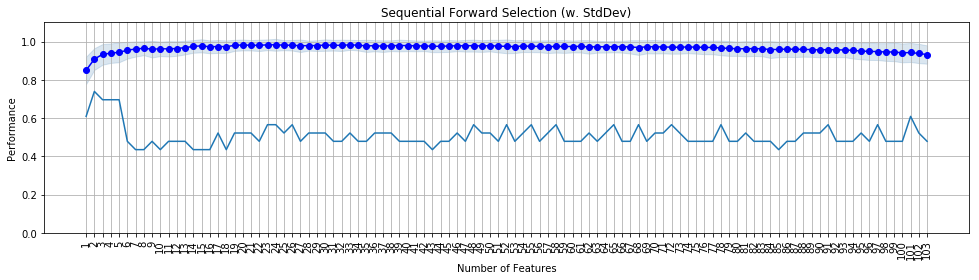

In [13]:
plot_subsets(sfs_rf, erasmus, clf=RandomForestClassifier(n_estimators=100), ylim=[0,1.1])

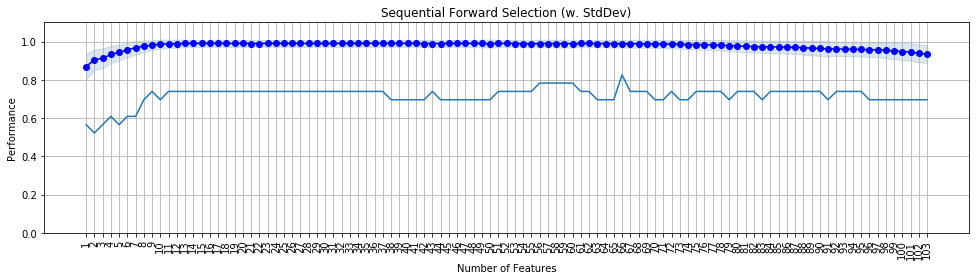

In [14]:
plot_subsets(sfs_logreg, erasmus, ylim=[0,1.1])

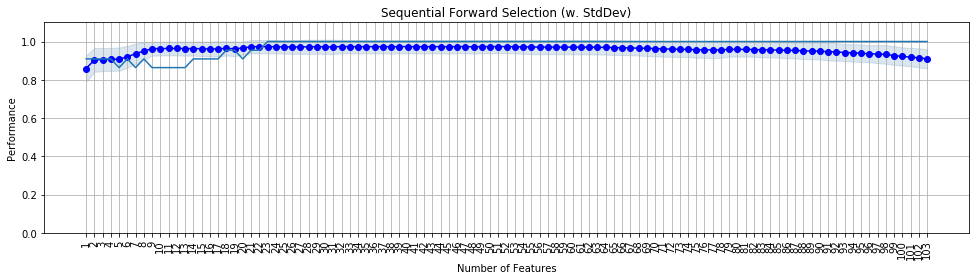

In [15]:
plot_subsets(sfs_logreg_alt, erasmus=None, ylim=[0,1.1])

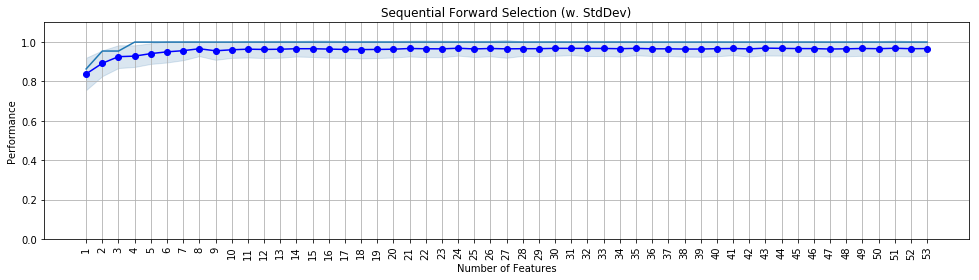

In [16]:
plot_subsets(sfs_rf_alt, erasmus=None, ylim=[0,1.1])

In [ ]:
sfs_rf.get_metric_dict()[8]

In [ ]:
sfs_logreg.get_metric_dict()[13]['feature_names']

In [ ]:
plot_subsets(sfs_rf)

In [ ]:
lr_parsimonious = list(sfs_logreg.get_metric_dict()[13]['feature_names'])
rf_parsimonious = list(sfs_rf.get_metric_dict()[8]['feature_names'])

# Classification

In [ ]:
classification(df, erasmus, sfs_logreg.estimator, lr_parsimonious)

In [ ]:
classification(df, erasmus, sfs_rf.estimator, list(sfs_rf.get_metric_dict()[3]['feature_names']))    

In [ ]:
classification(df, erasmus, LogisticRegression(solver='lbfgs'), sffs_float_cols)    

# Find Differences

In [ ]:
def preprocess_single(X_train):
    pre_steps = [
        ('logscale', FunctionTransformer(np.log1p, validate=True)),
        ('normalize', StandardScaler())
    ]
    transform = Pipeline(pre_steps)
    transform.fit(X_train)
    
    traincols = X_train.columns
    
    X_train = transform.transform(X_train)
    
    X_train = pd.DataFrame(X_train, columns=traincols)
    return X_train

In [ ]:
groups = list(combine.pop('Cohort'))
combine = preprocess_single(combine)
combine = pd.concat([pd.DataFrame(groups), combine], axis=1)

In [ ]:
colslol = pd.Series(combine.columns)
colslol.iloc[0] = 'Cohort'
combine.columns = colslol

In [ ]:
combine_lng = combine.melt(id_vars='Cohort')

In [ ]:
g = sns.catplot(x='Cohort', y='value', col='variable', col_wrap=4, data=combine_lng)

In [ ]:
# EVALUATION
# get highly correlated features with best model
# display heatmap of these features
# permute these features within groups and graph cross validated accuracy